# TP3 - ICV:  Reconhecimento de Captcha

## Marcos Vinicius - 2018054982
## Matheus Pimenta - 2018054893

### Introdução

Esse trabalho tem como objetivo implementar um método que reconheça todos os seis caracteres de imagens de captchas. Foram disponibilizados dados de treinamento, validação e teste. O método para o reconhecimento é livre.

Escolhemos montar uma CNN, com 4 camadas de convolução e 2 camadas densas. Dividimos cada captcha em 6 blocos, cada um contendo um caracter. Em seguida, treinamos a rede com 15 épocas, e avaliamos o modelo.

Comandos utilizados:

*pip install matplotlib*

*pip install tensorflow*

*pip install keras*

*pip install opencv-python*

*pip install scikit-learn*


## Bibliotécas

In [ ]:
import numpy as np
import cv2
import os
from keras.utils import np_utils
from matplotlib import pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Baixando o dataset

Nos comandos abaixo estamos baixando o arquivo dados.zip para o trabalho, e descomprimindo para o ambiente do notebook.

In [ ]:
!wget https://www.dropbox.com/s/itfqyh1trx9da7b/dados.zip

--2022-07-15 01:51:53--  https://www.dropbox.com/s/itfqyh1trx9da7b/dados.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/itfqyh1trx9da7b/dados.zip [following]
--2022-07-15 01:51:54--  https://www.dropbox.com/s/raw/itfqyh1trx9da7b/dados.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc68972b506831d8e9f67c252f14.dl.dropboxusercontent.com/cd/0/inline/BpGT3dazWeEkyQWfQiO9CCNlwWA0HsuW0L9m-drMmNk3Cbty25skVifKC22aCGfp67X1o9tLsZsqnPDugOZMVKcoNdaap462-PmaNk0HA6YT04oZw4Dzl64-bSFTkacdsbKbJP6kCgHML3krIChvPgGJT0oauy1LbTTipBiweIcDkA/file# [following]
--2022-07-15 01:51:54--  https://uc68972b506831d8e9f67c252f14.dl.dropboxusercontent.com/cd/0/inline/BpGT3dazWeEkyQWfQiO9CCNlwWA0HsuW0L9m-drMmNk3Cbty25skVifKC22aCGfp67X1o9tLsZ

In [ ]:
!unzip -u "dados.zip" -d "."

Archive:  dados.zip


## Lendo o dataset

Abaixo definimos métodos para ler os datasets e os ground-truth's. Como os resultados estão todos na mesma pasta, se relacionando com sua imagem a partir do nome dos arquivos, temos um método *get_file_id* que retorna o id comum entre o captcha e sua resposta. Usamos esse método no *read_dataset*, que retorna um array com as imagens, e outro com os respectivos ground-truth's.

In [ ]:
def get_file_id(file):
  filename = file.split('/');
  return filename[len(filename) - 1].split('.')[0]

def string_to_int(data):
  out = np.empty(6, dtype=np.int8)
  
  for i in range(len(data)):
    if ord(data[i]) >= ord('0') and ord(data[i]) <= ord('9'):
      out[i] = ord(data[i]) - ord('0') + (ord('Z') - ord('A'))

    if ord(data[i]) >= ord('A') and ord(data[i]) <= ord('Z'):
      out[i] = ord(data[i]) - ord('A')

  return out

def cat2char(c):
  if c > 25:
    return  chr(c + ord('0') - (ord('Z') - ord('A')))

  return  chr(c + ord('A'))

def catarray2string(c):
  out = ""
  for i in range(6):
    out = out + cat2char(c[i])
  return out

def read_dataset(dataset):
  labels = np.empty(0)
  files = os.listdir('./dados/CAPTCHA-10k/' + dataset + '/')
  
  Y = np.empty([len(files), 6], dtype=np.int8)
  X = [[] for i in range(len(files))];

  count = 0

  for file in files:
    id = get_file_id(file)
    
    y = open('dados/CAPTCHA-10k/labels10k/' + id + '.txt', 'rt').readline()
    x = cv2.imread('dados/CAPTCHA-10k/'+dataset+'/' + id + '.jpg', 0)
    
    Y[count] = string_to_int(y[0:6])
    X[count] = x

    count = count + 1

  return X, Y

Abaixo, algumas das imagens do dado de treino, e suas respectivas respostas.

<Figure size 432x288 with 0 Axes>

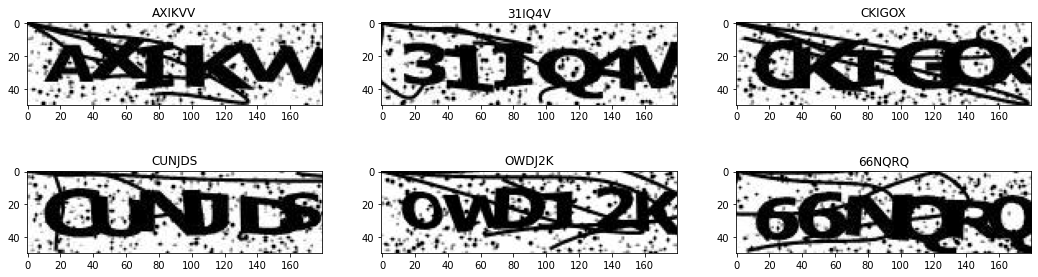

(50, 180)


In [ ]:
plt.set_cmap("gray")

X_train, Y_train = read_dataset('treinamento')
X_testing, Y_testing = read_dataset('teste')
X_validation, Y_validation = read_dataset('validacao')

fig = plt.figure(figsize=(18,5))

columns = 3
rows = 2

for i in range(columns*rows):
    img = X_train[i]
    
    x = fig.add_subplot(rows, columns, i + 1)
    x.set_title(catarray2string(Y_train[i]))
    
    plt.imshow(img)

plt.show()
print(X_testing[0].shape)

## Extraindo os caracteres

Um dos grandes desafios foi definir o tamanho da janela que usaríamos para pegar os caractéres, uma vez que o tamanho e a posição relativa de cada um varia bastante entre as imagens. Começamos pegando 32x32, partindo do quadrado ((9,0), (41,32)), e deslizando a janela 28px para a direita. Obtivemos uma perda de aprox. 20%  e 82% de acurácia no dado de teste. 

Decidimos por não começar do 0, mas sim andar um pouco para a direita. Também, variamos o tamanho da janela. Depois de diversos testes, melhor valor foi um retângulo de 30x28px, começando de ((12,12),(40,42)), e andando 28px (evitando overlap entre as janelas). 

Abaixo, temos uma imagem mostrando as divisões.

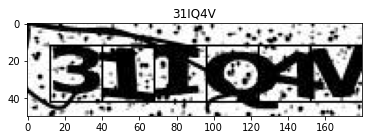

In [ ]:
def divide_image(img):
  width_left = 12
  width_right = 40
  height_left = 12
  height_right = 42

  di = img.copy()
  
  for i in range(6):
    cv2.rectangle(di, (width_left, height_left), (width_right, height_right), (0,255,0), 1)
    width_left = width_right
    width_right += 28
  
  return di

plt.title(catarray2string(Y_train[1]))
plt.imshow(divide_image(X_train[1]))

Nessa imagem o resultado foi satisfatório, mas isso não ocorre sempre:

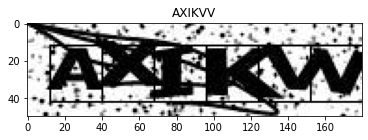

In [ ]:
plt.title(catarray2string(Y_train[0]))
plt.imshow(divide_image(X_train[0]));

Podemos perceber que o segundo M está com quase metáde na última divisão. Contudo, ainda pegou bem os outros, e essa janela gerou bons resultados no modelo.

Vamos definir agora métodos para extrair esses caractéres, e colocar em arrays para treinarmos.

In [ ]:
def get_chars_from_img(img):
    list_img_char = np.empty([6, 30, 28])

    width_left = 12
    width_right = 40
    height_left = 12
    height_right = 42

    for i in range(6):
      img_char = img[height_left:height_right,width_left:width_right]
      width_left = width_right
      width_right += 28
      list_img_char[i] = img_char

    return list_img_char

def extract_chars_from_images(images):
  data = np.empty([len(images)*6, 30, 28])
  size = 0

  for image in images:
    letters = get_chars_from_img(image)
    for i in range(6):
      data[size + i] = letters[i]
    size = size + 6
  return data

X_train_data = extract_chars_from_images(X_train)
X_train_data = X_train_data.astype('float32')
X_train_data /= 255

X_validation_data = extract_chars_from_images(X_validation)
X_validation_data = X_validation_data.astype('float32')
X_validation_data /= 255

X_testing_data = extract_chars_from_images(X_testing)
X_testing_data = X_testing_data.astype('float32')
X_testing_data /= 255

Y_train_data = Y_train.reshape(Y_train.shape[0]*Y_train.shape[1])
Y_train_data = np_utils.to_categorical(Y_train_data, 36)

Y_validation_data = Y_validation.reshape(Y_validation.shape[0]*Y_validation.shape[1])
Y_validation_data = np_utils.to_categorical(Y_validation_data, 36)

Y_testing_data = Y_testing.reshape(Y_testing.shape[0]*Y_testing.shape[1])
Y_testing_data = np_utils.to_categorical(Y_testing_data, 36)

print("Dimensões:")
print("X_train: ", X_train_data.shape)
print("Y_train: ", Y_train_data.shape)
print("X_validation: ", X_validation_data.shape)
print("Y_validation: ", Y_validation_data.shape)
print("X_testing: ", Y_testing_data.shape)
print("Y_testing: ", Y_testing_data.shape)



Dimensões:
X_train:  (48000, 30, 28)
Y_train:  (48000, 36)
X_validation:  (6000, 30, 28)
Y_validation:  (6000, 36)
X_testing:  (6000, 36)
Y_testing:  (6000, 36)


Abaixo, alguns caractéres extraídos, e seus respectíveis labels

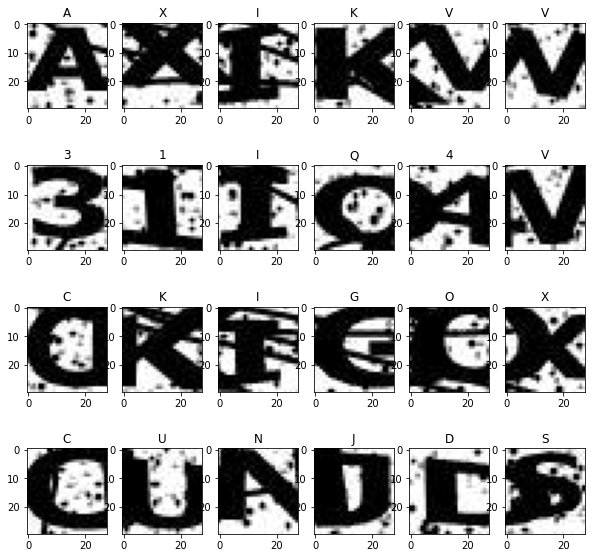

In [ ]:
fig = plt.figure(figsize=(10, 10))

columns = 6
rows = 4

def category_to_char(cat):
  i = 0

  for i in range(36):
    if cat[i] == 1:
      return cat2char(i)
  
  return chr(0)

for i in range(columns*rows):
    img = X_train_data[i]

    x = fig.add_subplot(rows, columns, i + 1)

    x.set_title("".join([category_to_char(Y_train_data[i])]))
    
    plt.imshow(img)
plt.show()

## Definindo o modelo e treinamento

O modelo escolhido foi uma CNN com 4 convoluções e 2 camadas densas. Começamos nos baseando na LeNet, mas adicionando mais camadas obtivemos melhores resultados.

O modelo tem 36 saídas para que consigamos traduzir o índice do maior valor diretamente para o caracter resultante.

In [ ]:
model = Sequential()

model.add(Conv2D(50, (5, 5), strides=(1, 1), activation='relu', padding='same', input_shape=(30,28,1)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(40, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(90, (5, 5), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(40, (5, 5), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(84, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(36, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 28, 50)        1300      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 14, 50)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 15, 14, 40)        50040     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 40)         0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 5, 5, 40)          0         
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 90)         

O otimizador escolhido foi o *adam*, e a perda foi a *categorical_crossentropy*. Já o número de épocas escolhido foi 15: abaixo dele, o modelo ainda tem espaço para melhorar. Acima, não tem grandes avanços, e deixar muito mais que isso pode gerar overfitting.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
X_train_data = tf.stack(X_train_data)
Y_train_data = tf.stack(Y_train_data)

X_validation_data = tf.stack(X_validation_data)
Y_validation_data = tf.stack(Y_validation_data)

response = model.fit(X_train_data, Y_train_data, validation_data=(X_validation_data, Y_validation_data), batch_size=128, epochs=15, verbose=1)

Epoch 1/15
375/375 [==============================] - 5s 11ms/step - loss: 1.2732 - accuracy: 0.6235 - val_loss: 0.2594 - val_accuracy: 0.9180
Epoch 2/15
375/375 [==============================] - 4s 10ms/step - loss: 0.3540 - accuracy: 0.8943 - val_loss: 0.1970 - val_accuracy: 0.9368
Epoch 3/15
375/375 [==============================] - 4s 10ms/step - loss: 0.2690 - accuracy: 0.9211 - val_loss: 0.1617 - val_accuracy: 0.9507
Epoch 4/15
375/375 [==============================] - 4s 11ms/step - loss: 0.2295 - accuracy: 0.9331 - val_loss: 0.1544 - val_accuracy: 0.9527
Epoch 5/15
375/375 [==============================] - 4s 11ms/step - loss: 0.2097 - accuracy: 0.9387 - val_loss: 0.1396 - val_accuracy: 0.9570
Epoch 6/15
375/375 [==============================] - 4s 10ms/step - loss: 0.1935 - accuracy: 0.9434 - val_loss: 0.1450 - val_accuracy: 0.9612
Epoch 7/15
375/375 [==============================] - 4s 11ms/step - loss: 0.1792 - accuracy: 0.9460 - val_loss: 0.1369 - val_accuracy: 0.9595

Abaixo, temos uma comparação entre as variações da perda e da acurácia entre o dado de treino e o de validação. No final, ambos tiveram perdas entre aprox. 0.12 e 0.15 e acurácia de aprox. 0.95-0.96.

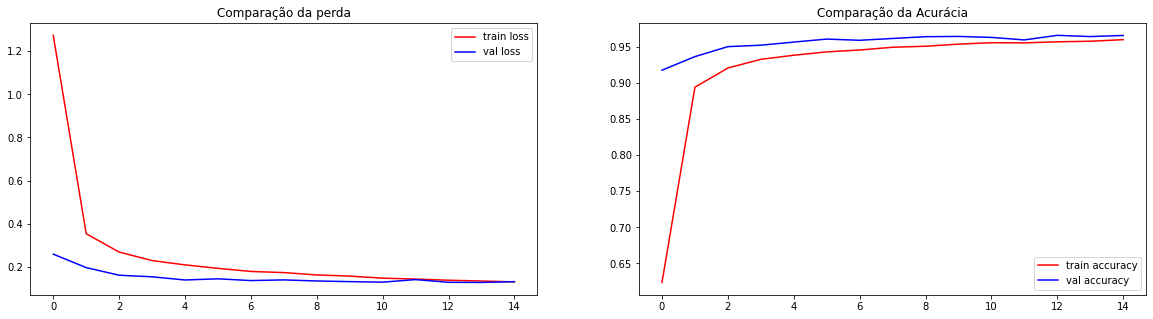

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(response.history["loss"], color='r', label = 'train loss')
axis[0].plot(response.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Comparação da perda')
axis[0].legend()
axis[1].plot(response.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(response.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Comparação da Acurácia')
axis[1].legend()

## Testando o modelo

Vamos agora testar o modelo nos dados de teste. Para avaliar, primeiro vamos usar o método *model.evaluate*, que dado X e Y, retorna a perda e a acurácia que o modelo teve no dado.

In [ ]:
X_testing_data = tf.stack(X_testing_data)
Y_testing_data = tf.stack(Y_testing_data)

print("Evaluate on test data")
results = model.evaluate(X_testing_data, Y_testing_data, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
188/188 [==============================] - 1s 4ms/step - loss: 0.1560 - accuracy: 0.9602
test loss, test acc: [0.15597964823246002, 0.9601666927337646]


Agora vamos gerar a matriz de confusão, e exibi-la com auxílio do método *ConfusionMatrixDisplay*

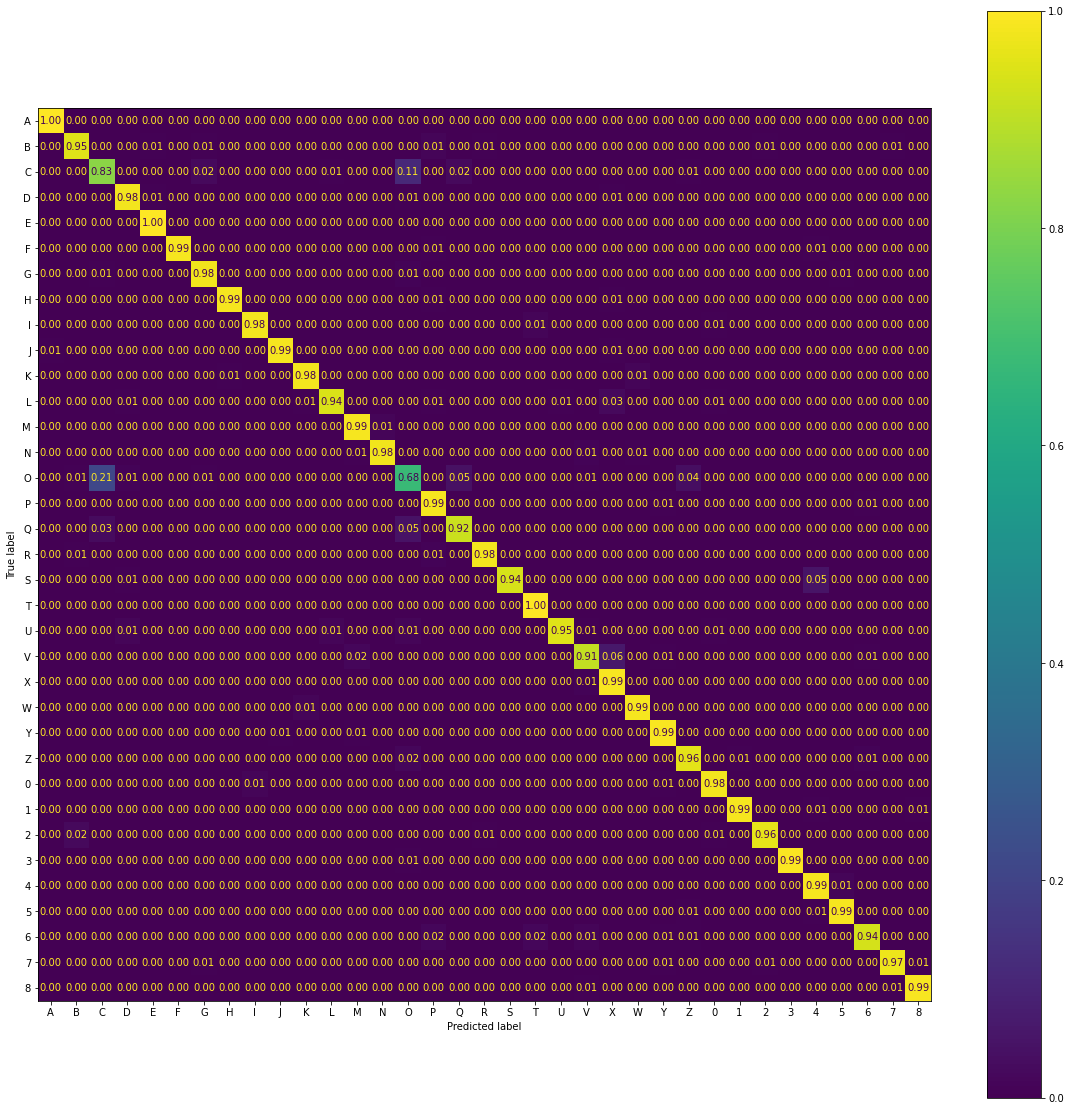

In [ ]:
prediction = model.predict(X_testing_data)


labels = [
          "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", 
          "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", 
          "U", "V", "X", "W", "Y", "Z", "0", "1", "2", "3", 
          "4", "5", "6", "7", "8", "9"
]

Y_pred = np.empty(prediction.shape)

for i in range(len(prediction)):
  Y_pred[i] = np.zeros([36])
  Y_pred[i][np.where(prediction[i] == max(prediction[i]))[0][0]] = 1


A = np.argmax(Y_testing_data,axis=1)
B = np.argmax(prediction,axis=1)

cm = confusion_matrix(A, B, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(20,20))

disp.plot(ax=ax, values_format='.2f')

Podemos perceber que o modelo consegue reconhecer a maioria dos caractéres, com quase todos na diagonal principal acima de 0.9. Os piores resultados foram o 'O' e o 'C' que foram bastante confundidos um com o outro, e com o 'Q' também.

Esses erros são provavelmente do método de extração dos caractéres, pois como a janela é fixa, pode ocorrer de pegar só um pedaço, ou um caracter sobrepor o outro, o que dificulta para o modelo chegar aos 100% de acurácia.

Vamos visualizar o resultado do modelo para algumas entradas

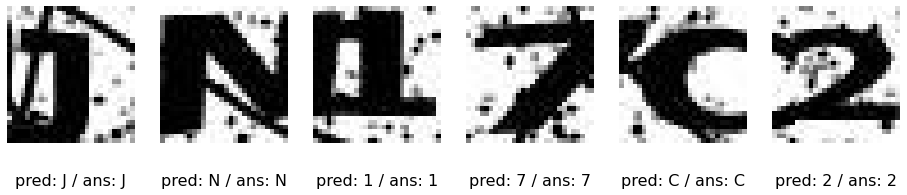

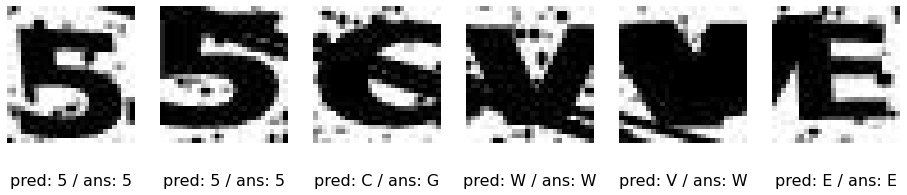

In [ ]:
def predict_to_char(pred, idx):
  return cat2char(np.where(pred[idx] == max(pred[idx]))[0][0])

predictions = model.predict(X_testing_data)

fig = plt.figure(figsize=(16, 16))
for i in range(6):
  x = fig.add_subplot(2, 6, i + 1)
  title = "pred: " + category_to_char(Y_testing_data[i]) + " / ans: " + predict_to_char(predictions, i)
  x.set_title(title, y=-0.35, fontsize=16)
  plt.axis('off')
  plt.imshow(X_testing_data[i])

plt.show()

fig = plt.figure(figsize=(16, 16))
for i in range(6):
  x = fig.add_subplot(2, 6, i + 1)
  title = "pred: " + category_to_char(Y_testing_data[i+6]) + " / ans: " + predict_to_char(predictions, i+6)
  x.set_title(title, y=-0.35, fontsize=16)
  plt.axis('off')
  plt.imshow(X_testing_data[i+6])

plt.show()
  

Agora, vamos definir um método para avaliar todo o captcha. Vamos aproveitar e retornar quantos caractéres de cada captcha foram corretamente identificados, para podermos gerar o gráfico da taxa de reconhecimento em função do número mínimode matches.

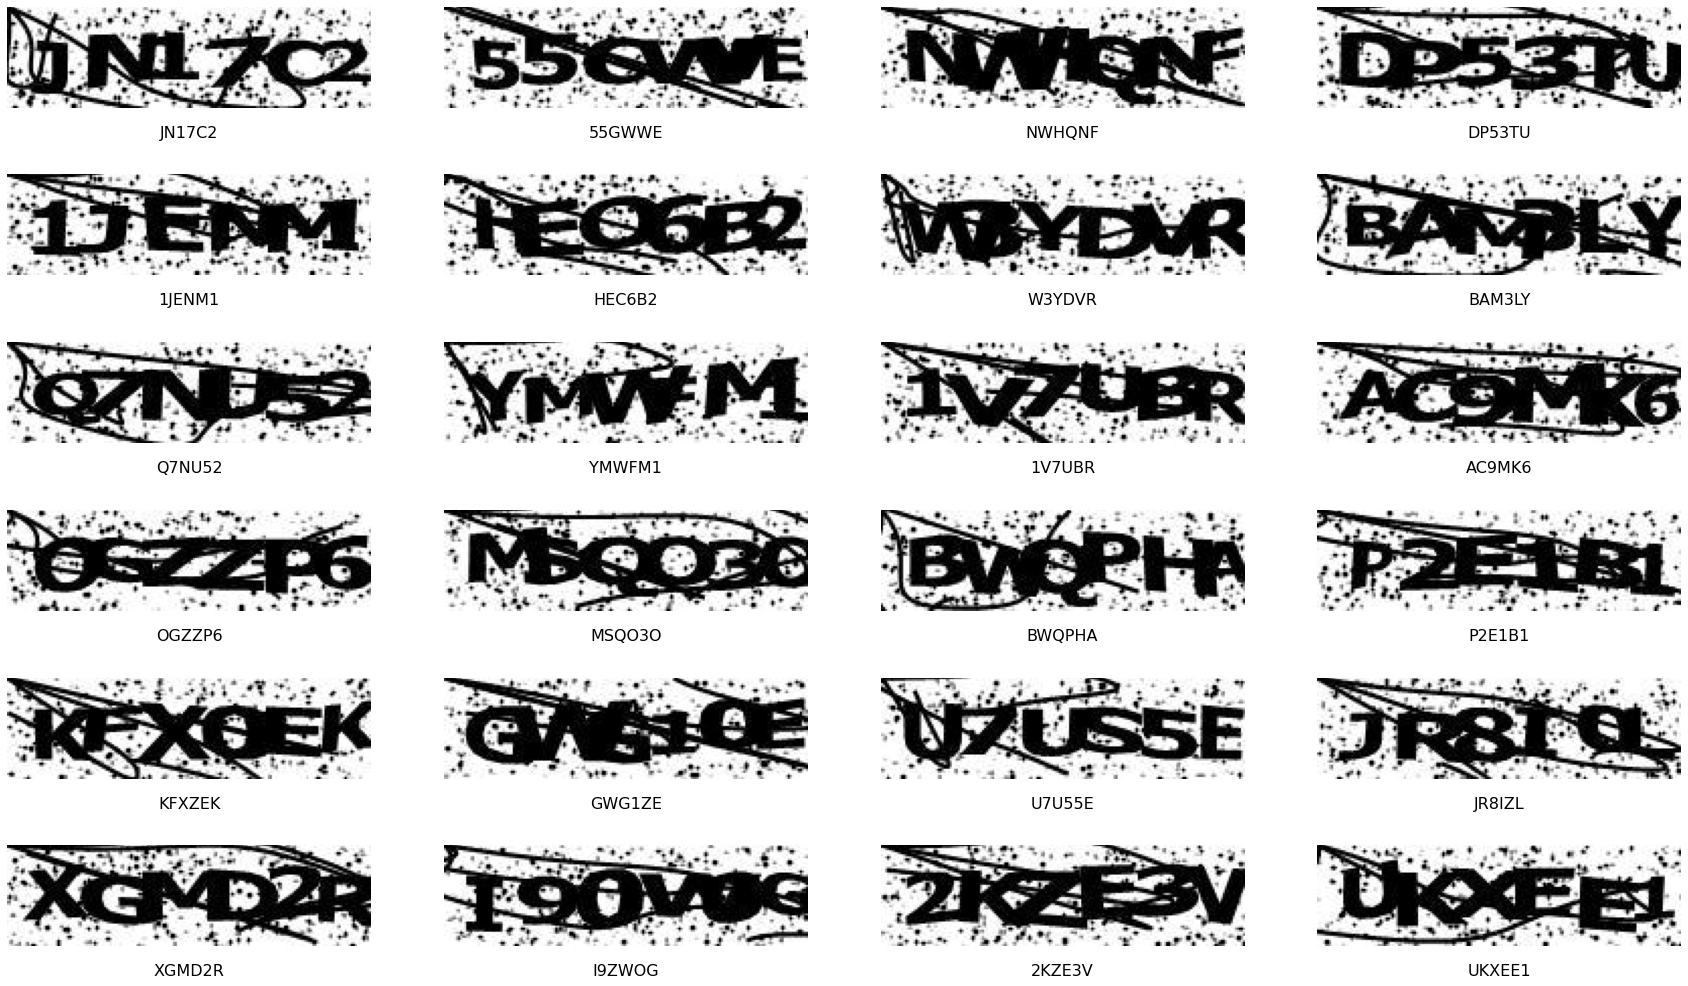

In [ ]:
def evaluate_captcha(idx):
  ground_truth = ""
  pred_char = ""
  matches = 0
  for i in range(idx*6, idx*6+6):
    y = category_to_char(Y_testing_data[i])
    ground_truth = ground_truth +  y

    p = predict_to_char(predictions, i)
    pred_char = pred_char + p

    if p==y:
      matches += 1

  return pred_char, ground_truth, matches

matches_list = [0,0,0,0,0,0,0]
num_img_to_display = 24

fig = plt.figure(figsize=(30, (num_img_to_display/4)*3))
for i in range(num_img_to_display):
  x = fig.add_subplot(num_img_to_display/4, 4, i + 1)
  pred, _, match = evaluate_captcha(i)
  matches_list[match] += 1
  plt.imshow(X_testing[i])
  x.set_title(pred, y=-0.35, fontsize=16)
  plt.axis('off')
plt.show()

Por fim, vamos gerar o gráfico citado anteriormente, mostrando a taxa de reconhecimento em função do número mínimo de caracteres que foram corretamente reconhecidos por captcha, de acordo com o ground-truth. 

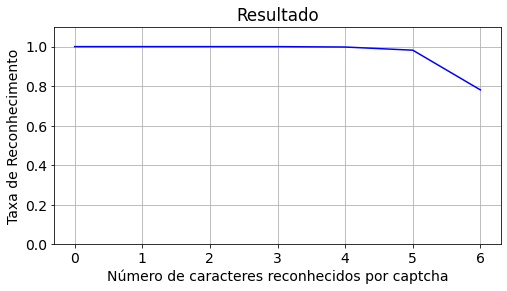

In [ ]:
matches_list = [0,0,0,0,0,0,0]
for i in range(len(X_testing)):
  _, _, match = evaluate_captcha(i)
  matches_list[match] += 1


x = [0,1,2,3,4,5,6]
y = [0,0,0,0,0,0,0]
for i in range(0, 7):
  if i==0:
    y[6-i] = matches_list[6-i]/len(X_testing)
  else:
    y[6-i] = y[7-i] + matches_list[6-i]/len(X_testing)

plt.rcParams.update({'font.size':14})
plt.rcParams["figure.figsize"] = (8,4)
fig, ax = plt.subplots()
plt.title("Resultado")
ax.set_ylim(bottom=0, top=1.1)
plt.xlabel("Número de caracteres reconhecidos por captcha")
plt.ylabel("Taxa de Reconhecimento")
plt.grid()
plt.plot(x, y, color = 'blue')
plt.show()

In [ ]:
print(matches_list)

[0, 0, 0, 2, 16, 201, 781]
